# GAN Evaluation

* Credit: Ziqiao Ma
* Latest Update: Dec.16 2020


## Colab Setup

### Environment Configuration

Mount to Colab and set up autoreload module.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


TODO: Change the variable to the locaation of your file in the drive!

In [18]:
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/StarGAN-V1'

In [19]:
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
sys.path.append(GOOGLE_DRIVE_PATH)
print(os.listdir(GOOGLE_DRIVE_PATH))

['checkpoints', 'StarGANv1_10w.ipynb']


Set up file system.

### Import Libraries

In [5]:
import matplotlib.pyplot as plt

import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint

from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data

from skimage.transform import resize
from skimage.io import imread_collection

## Frechet Inception Distance (FID)

The Frechet Inception Distance score, or FID for short, is a metric that **calculates the distance between feature vectors calculated for real and generated images**.

The score summarizes how similar the two groups are in terms of statistics on computer vision features of the raw images calculated using the inception v3 model used for image classification. Lower scores indicate the two groups of images are more similar, or have more similar statistics, with a perfect score being 0.0 indicating that the two groups of images are identical.

The FID score is used to evaluate the quality of images generated by generative adversarial networks, and lower scores have been shown to correlate well with higher quality images.

Reference: [Tutorial](https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/).

### Implementation

In [6]:
def calculate_fid(model, images1, images2):

	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
 
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
 
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
 
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
 
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real

	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Prepared (100, 256, 256, 3) (200, 256, 256, 3)


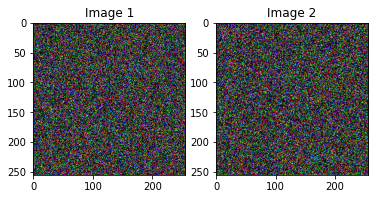

In [7]:
# define two fake collections of images
images1 = randint(0, 255, 100*256*256*3)
images1 = images1.reshape((100,256,256,3))
images2 = randint(0, 255, 200*256*256*3)
images2 = images2.reshape((200,256,256,3))
print('Prepared', images1.shape, images2.shape)

# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')

# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)

# Visualize
plt.subplot(121)
plt.title('Image 1')
plt.imshow(images1[0])
plt.subplot(122)
plt.title('Image 2')
plt.imshow(images2[0])

In [8]:
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(256,256,3))

# fid between images1 and images1
fid = calculate_fid(model, images1, images1)
print('FID of same images: %.3f' % fid)

# fid between images1 and images2
fid = calculate_fid(model, images1, images2)
print('FID of different images: %.3f' % fid)

87916544/87910968 [==============================] - 1s 0us/step
FID of same images: -0.000
FID of different images: 18.903


### Evaluation

It's useful to calculate the FID score between two collections of real images.

In [9]:
# Create data/
!mkdir data/
!mkdir data/style/
!mkdir data/style/train/
!mkdir data/style/test/

# Download Datasets from UCB
!wget -cO - https://people.eecs.berkeley.edu/%7Etaesung_park/CycleGAN/datasets/cezanne2photo.zip > cezanne.zip
!wget -cO - https://people.eecs.berkeley.edu/%7Etaesung_park/CycleGAN/datasets/monet2photo.zip > monet.zip
!wget -cO - https://people.eecs.berkeley.edu/%7Etaesung_park/CycleGAN/datasets/ukiyoe2photo.zip > ukiyoe.zip
!wget -cO - https://people.eecs.berkeley.edu/%7Etaesung_park/CycleGAN/datasets/vangogh2photo.zip > vangogh.zip

# Unzip files
!unzip cezanne.zip
!unzip monet.zip
!unzip ukiyoe.zip
!unzip vangogh.zip

!rm -f cezanne.zip
!mv cezanne2photo/trainA/ data/style/train/cezanne/
!mv cezanne2photo/testA/ data/style/test/cezanne/
!mv cezanne2photo/trainB/ data/style/train/photo/
!mv cezanne2photo/testB/ data/style/test/photo/
!rm -r cezanne2photo/

!rm -f monet.zip
!mv monet2photo/trainA/ data/style/train/monet/
!mv monet2photo/testA/ data/style/test/monet/
!rm -r monet2photo/

!rm -f ukiyoe.zip
!mv ukiyoe2photo/trainA/ data/style/train/ukiyoe/
!mv ukiyoe2photo/testA/ data/style/test/ukiyoe/
!rm -r ukiyoe2photo/

!rm -f vangogh.zip
!mv vangogh2photo/trainA/ data/style/train/vangogh/
!mv vangogh2photo/testA/ data/style/test/vangogh/
!rm -r vangogh2photo/

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: vangogh2photo/trainB/2016-08-26 19:25:29.jpg  
  inflating: vangogh2photo/trainB/2016-02-20 16:54:25.jpg  
  inflating: vangogh2photo/trainB/2015-05-19 19:43:44.jpg  
  inflating: vangogh2photo/trainB/2015-10-26 21:18:58.jpg  
  inflating: vangogh2photo/trainB/2014-07-19 15:39:53.jpg  
  inflating: vangogh2photo/trainB/2015-06-13 21:21:54.jpg  
  inflating: vangogh2photo/trainB/2015-06-04 14:10:33.jpg  
  inflating: vangogh2photo/trainB/2014-06-18 12:46:34.jpg  
  inflating: vangogh2photo/trainB/2016-03-17 18:07:22.jpg  
  inflating: vangogh2photo/trainB/2015-01-24 17:24:29.jpg  
  inflating: vangogh2photo/trainB/2016-01-27 12:45:41.jpg  
  inflating: vangogh2photo/trainB/2016-06-14 05:57:28.jpg  
  inflating: vangogh2photo/trainB/2015-12-24 01:48:36.jpg  
  inflating: vangogh2photo/trainB/2015-10-18 05:19:51.jpg  
  inflating: vangogh2photo/trainB/2015-01-23 07:43:34.jpg  
  inflating: vangogh2photo/trainB/2016-04-29 18:08:01.jpg  
  inflating: 

In [10]:
TRAIN_IMG_DIR = 'data/style/train'
TEST_IMG_DIR = 'data/style/test'

In [11]:
def load_img_dir(label='photo', size=None):
  assert label in {'photo', 'cezanne', 'monet', 'ukiyoe', 'vangogh'}
  dir_photo = os.path.join(TEST_IMG_DIR, '{}/*.jpg'.format(label))
  img_photo = numpy.array(imread_collection(dir_photo))

  if size is None:
    size = len(img_photo)
  else:
    img_photo = img_photo[:size]

  img_photo = img_photo.reshape((size,256,256,3)).astype('float32')
  img_photo = preprocess_input(img_photo)
  return img_photo

In [25]:
model = InceptionV3(include_top=False, pooling='avg', input_shape=(256, 256, 3))

size = 4
print('Loading images...')
img_photo = load_img_dir('photo', size)
img_cezanne = load_img_dir('cezanne', size)
img_monet = load_img_dir('monet', size)
img_ukiyoe = load_img_dir('ukiyoe', size)
img_vangogh = load_img_dir('vangogh', size)

print('Start testing...')
fid = calculate_fid(model, img_photo, img_cezanne)
print('FID between photo and cezanne: %.3f' % fid)

fid = calculate_fid(model, img_photo, img_monet)
print('FID between photo and monet: %.3f' % fid)

fid = calculate_fid(model, img_photo, img_ukiyoe)
print('FID between photo and ukiyoe: %.3f' % fid)

fid = calculate_fid(model, img_photo, img_vangogh)
print('FID between photo and vangogh: %.3f' % fid)

fid = calculate_fid(model, img_cezanne, img_monet)
print('FID between cezanne and monet: %.3f' % fid)

fid = calculate_fid(model, img_cezanne, img_ukiyoe)
print('FID between cezanne and ukiyoe: %.3f' % fid)

fid = calculate_fid(model, img_cezanne, img_vangogh)
print('FID between cezanne and vangogh: %.3f' % fid)

fid = calculate_fid(model, img_monet, img_ukiyoe)
print('FID between monet and ukiyoe: %.3f' % fid)

fid = calculate_fid(model, img_monet, img_vangogh)
print('FID between monet and vangogh: %.3f' % fid)

fid = calculate_fid(model, img_ukiyoe, img_vangogh)
print('FID between ukiyoe and vangogh: %.3f' % fid)

Loading images...
Start testing...
FID between photo and cezanne: 722.152
FID between photo and monet: 660.981
FID between photo and ukiyoe: 632.575
FID between photo and vangogh: 713.891
FID between cezanne and monet: 647.105
FID between cezanne and ukiyoe: 576.691
FID between cezanne and vangogh: 634.665
FID between monet and ukiyoe: 640.442
FID between monet and vangogh: 682.915
FID between ukiyoe and vangogh: 629.556


In [13]:
def load_out_dir(dir, label='cezanne', size=None):
  assert label in {'cezanne', 'monet', 'ukiyoe', 'vangogh'}
  dir_photo = os.path.join(dir, '{}/*.jpg'.format(label))
  img_photo = numpy.array(imread_collection(dir_photo))

  if size is None:
    size = len(img_photo)
  else:
    img_photo = img_photo[:size]

  img_photo = img_photo.reshape((size,256,256,3)).astype('float32')
  img_photo = preprocess_input(img_photo)
  return img_photo

In [24]:
dir_cyclegan = os.path.join(GOOGLE_DRIVE_PATH, 'checkpoints/checkpoints_20w/one_result')
print(os.listdir(dir_cyclegan))

size = 4
print('Loading images...')
cyclegan_cezanne = load_out_dir(dir_cyclegan, 'cezanne', size)
cyclegan_monet = load_out_dir(dir_cyclegan, 'monet', size)
cyclegan_ukiyoe = load_out_dir(dir_cyclegan, 'ukiyoe', size)
cyclegan_vangogh = load_out_dir(dir_cyclegan, 'vangogh', size)

print('Start testing...')
fid = calculate_fid(model, img_cezanne, cyclegan_cezanne)
print('FID between cyclegan generated fake cezanne and test cyclegan images: %.3f' % fid)

fid = calculate_fid(model, img_monet, cyclegan_monet)
print('FID between cyclegan generated fake monet and test cyclegan monet: %.3f' % fid)

fid = calculate_fid(model, img_ukiyoe, cyclegan_ukiyoe)
print('FID between cyclegan generated fake ukiyoe and test cyclegan ukiyoe: %.3f' % fid)

fid = calculate_fid(model, img_vangogh, cyclegan_vangogh)
print('FID between cyclegan generated fake vangogh and test cyclegan vangogh: %.3f' % fid)

['cezanne', 'ukiyoe', 'monet', 'vangogh']
Loading images...
Start testing...
FID between cyclegan generated fake cezanne and test cyclegan images: 482.198
FID between cyclegan generated fake monet and test cyclegan monet: 595.773
FID between cyclegan generated fake ukiyoe and test cyclegan ukiyoe: 543.216
FID between cyclegan generated fake vangogh and test cyclegan vangogh: 598.001


In [15]:
dir_cyclegan = os.path.join(GOOGLE_DRIVE_PATH, 'results/')
print(os.listdir(dir_cyclegan))

size = 100
print('Loading images...')
cyclegan_cezanne = load_out_dir(dir_cyclegan, 'cezanne', size)
cyclegan_monet = load_out_dir(dir_cyclegan, 'monet', size)
cyclegan_ukiyoe = load_out_dir(dir_cyclegan, 'ukiyoe', size)
cyclegan_vangogh = load_out_dir(dir_cyclegan, 'vangogh', size)

print('Start testing...')
fid = calculate_fid(model, img_cezanne, cyclegan_cezanne)
print('FID between cyclegan generated fake cezanne and test cyclegan images: %.3f' % fid)

fid = calculate_fid(model, img_monet, cyclegan_monet)
print('FID between cyclegan generated fake monet and test cyclegan monet: %.3f' % fid)

fid = calculate_fid(model, img_ukiyoe, cyclegan_ukiyoe)
print('FID between cyclegan generated fake ukiyoe and test cyclegan ukiyoe: %.3f' % fid)

fid = calculate_fid(model, img_vangogh, cyclegan_vangogh)
print('FID between cyclegan generated fake vangogh and test cyclegan vangogh: %.3f' % fid)

['cezanne', 'monet', 'vangogh', 'ukiyoe', 'merged', 'StarGAN_v2_style']
Loading images...
Start testing...
FID between cyclegan generated fake cezanne and test cyclegan images: 410.008
FID between cyclegan generated fake monet and test cyclegan monet: 272.967
FID between cyclegan generated fake ukiyoe and test cyclegan ukiyoe: 491.754
FID between cyclegan generated fake vangogh and test cyclegan vangogh: 363.838
